# MIE451/1513 Decision Support System -- Data Science Solution

## Hotel analysis - Medicine Hat, AB


In [ ]:
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Packages
import math
import pandas as pd
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

## Data Visualization
import folium
from tabulate import tabulate
from scipy.stats.kde import gaussian_kde

## Geolocation
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [19]:
#Read in data
# For this assignment I used real review data for hotels in Medicine Hat - Alberta 
hotelData = pd.read_csv('reviews.csv')
hotelData.columns= ['filePath','hotelName','reviewColumn','ratingScore','groundTruth',
               'date_stamp','streetAddress', 'City',
               'Province','postalCode']
hotelData['reviewColumn'] = hotelData['reviewColumn'].astype('str')


In [194]:
hotelData

,filePath,hotelName,reviewColumn,ratingScore,groundTruth,date_stamp,streetAddress,City,Province,postalCode
0,./data/ca/154920/188360/748524190.html,Super 8 by Wyndham Medicine Hat AB,"""It was okay could us a couple upgrades. The s...",3,negative,"March 1, 2020",1280 Trans Canada Way SE,Medicine Hat,Alberta,T1B 1J5
1,./data/ca/154920/188360/349234610.html,Super 8 by Wyndham Medicine Hat AB,"""There was nothing fancy about this motel but ...",3,negative,"February 19, 2016",1280 Trans Canada Way SE,Medicine Hat,Alberta,T1B 1J5
2,./data/ca/154920/188360/439044260.html,Super 8 by Wyndham Medicine Hat AB,"""Base bord heaters were not working in room wa...",3,negative,"November 21, 2016",1280 Trans Canada Way SE,Medicine Hat,Alberta,T1B 1J5
3,./data/ca/154920/188360/425446798.html,Super 8 by Wyndham Medicine Hat AB,"""We stayed here on our way to Calgary and aga...",4,positive,"October 5, 2016",1280 Trans Canada Way SE,Medicine Hat,Alberta,T1B 1J5
4,./data/ca/154920/188360/420988714.html,Super 8 by Wyndham Medicine Hat AB,"""The first visit there we were not impressed. ...",5,positive,"September 21, 2016",1280 Trans Canada Way SE,Medicine Hat,Alberta,T1B 1J5
...,...,...,...,...,...,...,...,...,...,...
1409,./data/ca/3579457/647472/768355250.html,Elkwater Lake Lodge,"""My wife and I made our first trip to the Cypr...",5,positive,"September 1, 2020",401 4th Street Elkwater Lake Lodge & Resort,Elkwater,Alberta,T0J 1C0
1410,./data/ca/3579457/647472/419997091.html,Elkwater Lake Lodge,"""We stayed in Room110 for two nights and wish ...",5,positive,"September 18, 2016",401 4th Street Elkwater Lake Lodge & Resort,Elkwater,Alberta,T0J 1C0
1411,./data/ca/3579457/647472/527450625.html,Elkwater Lake Lodge,"""I visited Elkwater with my boyfriend to celeb...",5,positive,"September 25, 2017",401 4th Street Elkwater Lake Lodge & Resort,Elkwater,Alberta,T0J 1C0
1412,./data/ca/3579457/647472/421042327.html,Elkwater Lake Lodge,"""We highly recommend this quiet, clean and fri...",5,positive,"September 21, 2016",401 4th Street Elkwater Lake Lodge & Resort,Elkwater,Alberta,T0J 1C0


In [21]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pd.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [22]:
reviews = hotelData['reviewColumn'].values

In [23]:
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])


100%|██████████| 1414/1414 [00:01<00:00, 920.95it/s]


In [24]:
reviewDF.head()

,reviewCol,vader
0,"""It was okay could us a couple upgrades. The s...",-0.8451
1,"""There was nothing fancy about this motel but ...",0.6474
2,"""Base bord heaters were not working in room wa...",-0.3085
3,"""We stayed here on our way to Calgary and aga...",0.9547
4,"""The first visit there we were not impressed. ...",0.1234


## Data Pre-processing 
1. Find Top-K words 

2. Build a dataframe with one-hot encoding for words present in each review

In [79]:
def get_stop_words():
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    stop.add('medicine') #add location names
    stop.add('hat')
    stop.add('alberta')
    stop.add('saskatchewan')
    return stop

def getTopKWords(df, kwords):

    stop = get_stop_words()
    counter = Counter()

    reviews = df['reviewCol'].values

    for review in reviews:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(kwords)
    return topk

# Note: You may want to use an NLTK tokenizer instead of a regular expression in the following
def dataFrameTransformation(hotelDf, reviewDF, topk):
    reviews = reviewDF['reviewCol'].values
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return finaldf


In [26]:
topk = getTopKWords(reviewDF, 500)
finaldf = dataFrameTransformation(hotelData, reviewDF, topk)

In [27]:
topk[:10]

[('breakfast', 827),
 ('clean', 759),
 ('good', 644),
 ('great', 621),
 ('would', 543),
 ('nice', 474),
 ('friendly', 459),
 ('pool', 439),
 ('comfortable', 377),
 ('stayed', 375)]

 ## Q1 - Sentiment analysis and aggregation

### (a) Compute average Vader sentiment and average ground truth rating per hotel.

In [29]:
finaldf.head()

,hotelName,ratingScore,groundTruth,reviewCol,vader,breakfast,clean,good,great,would,nice,friendly,pool,comfortable,stayed,one,desk,night,front,hot,place,time,well,bed,hat,medicine,get,like,price,area,helpful,back,service,could,nthe,beds,check,also,really,tub,...,half,facilities,priced,ice,start,facility,week,fun,must,juice,efficient,budget,tell,areas,group,brought,adequate,cleanliness,bedroom,choose,huge,western,nbreakfast,ended,may,plenty,appreciated,walls,daughter,gas,fact,decor,along,standard,dinner,scrambled,certainly,number,indian,welcome
0,Super 8 by Wyndham Medicine Hat AB,3,negative,"""It was okay could us a couple upgrades. The s...",-0.8451,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Super 8 by Wyndham Medicine Hat AB,3,negative,"""There was nothing fancy about this motel but ...",0.6474,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Super 8 by Wyndham Medicine Hat AB,3,negative,"""Base bord heaters were not working in room wa...",-0.3085,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Super 8 by Wyndham Medicine Hat AB,4,positive,"""We stayed here on our way to Calgary and aga...",0.9547,1,1,0,0,1,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Super 8 by Wyndham Medicine Hat AB,5,positive,"""The first visit there we were not impressed. ...",0.1234,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
def avg_rating_per_hotel(df):
  # average the scores over all hotels, you may need to provide additional filtering
  tempDf = df[['hotelName','vader','ratingScore','reviewCol']]
  tempDf.columns = ['hotelName','AverageVader', 'AverageRatingScore','n_reviews']
  tempDf = tempDf.groupby('hotelName').agg({'AverageVader':'mean', 'AverageRatingScore':'mean','n_reviews':'count'})
  return tempDf

In [55]:
avg_rating_df = avg_rating_per_hotel(finaldf)
avg_rating_df

,AverageVader,AverageRatingScore,n_reviews
hotelName,,,
Ace Crown Motel,-0.023300,3.000000,2
Baymont by Wyndham Medicine Hat,0.784708,4.270000,100
Best Western Premier Executive Residency Medicine Hat,0.948860,4.800000,5
Comfort Inn &amp; Suites Medicine Hat,0.811451,4.380000,100
Days Inn by Wyndham Medicine Hat,0.714159,4.360000,100
Elkwater Lake Lodge,0.665359,3.780000,100
Hampton Inn &amp; Suites by Hilton Medicine Hat,0.831068,4.550000,100
Hat Motel,-0.056233,2.333333,3
Holiday Inn Express and Suites Medicine Hat Transcanada Hwy 1,0.671272,4.040000,25


### (b) Rank hotels 
(i) Average Ground Truth Sentiment
(ii) Average Vader Compound Sentiment Score
Show both top-5 and bottom-5 for both ranking methods. Do they agree? If not discuss any differences.

In [68]:
# top 5 results  - ground truth rating
avgRatingTop5 = avg_rating_df.reset_index(drop=False)\
                               .sort_values('AverageRatingScore',ascending=False)[['hotelName','AverageRatingScore']].head(5)
avgRatingTop5



,hotelName,AverageRatingScore
2,Best Western Premier Executive Residency Medic...,4.80
6,Hampton Inn &amp; Suites by Hilton Medicine Hat,4.55
9,Home Inn Express Medicine Hat,4.40
3,Comfort Inn &amp; Suites Medicine Hat,4.38
4,Days Inn by Wyndham Medicine Hat,4.36


In [69]:
# top 5 results  - vader rating

avgVaderTop5 = avg_rating_df.reset_index(drop=False)\
                              .sort_values('AverageVader',ascending=False)[['hotelName','AverageVader']].head(5)
avgVaderTop5

,hotelName,AverageVader
2,Best Western Premier Executive Residency Medic...,0.948860
24,TownePlace Suites Medicine Hat,0.857960
6,Hampton Inn &amp; Suites by Hilton Medicine Hat,0.831068
9,Home Inn Express Medicine Hat,0.820584
14,Pals Motel and RV Park,0.818540


In [65]:
#bottom 5 - Ground truth rating
avgRatingbottom5 = avg_rating_df.reset_index(drop=False)\
                               .sort_values('AverageRatingScore',ascending=True)[['hotelName','AverageRatingScore']].head(5)
avgRatingbottom5

,hotelName,AverageRatingScore
20,Searra Motel,1.000000
21,Sun Dek Motel,2.307692
7,Hat Motel,2.333333
15,Parklane Motor Inn,2.500000
14,Pals Motel and RV Park,2.800000


In [66]:
# bottom 5 results  - vader rating

avgVaderbottom5 = avg_rating_df.reset_index(drop=False)\
                              .sort_values('AverageVader',ascending=True)[['hotelName','AverageVader']].head(5)
avgVaderbottom5

,hotelName,AverageVader
7,Hat Motel,-0.056233
0,Ace Crown Motel,-0.023300
23,TC Motel,0.188980
21,Sun Dek Motel,0.204573
15,Parklane Motor Inn,0.244650


In [70]:
#print results - top 5
print('Top 5 hotels avg rating vs. avg vader score:')

table = [[i,x,avgVaderTop5['hotelName'].iloc[i]] for i, x in enumerate(avgRatingTop5['hotelName'])]
headers = ["Rank(best first)", "avg Rating", "avg Vader"]

print(tabulate(table, headers, tablefmt="grid"))

Top 5 hotels avg rating vs. avg vader score:
+--------------------+-------------------------------------------------------+-------------------------------------------------------+
|   Rank(best first) | avg Rating                                            | avg Vader                                             |
+====================+=======================================================+=======================================================+
|                  0 | Best Western Premier Executive Residency Medicine Hat | Best Western Premier Executive Residency Medicine Hat |
+--------------------+-------------------------------------------------------+-------------------------------------------------------+
|                  1 | Hampton Inn &amp; Suites by Hilton Medicine Hat       | TownePlace Suites Medicine Hat                        |
+--------------------+-------------------------------------------------------+-------------------------------------------------------+
|         

In [72]:
#print resultss - bottom 5
print('Bottom 5 hotels avg rating vs. avg vader score:')

table = [[i,x,avgVaderbottom5['hotelName'].iloc[i]] for i, x in enumerate(avgRatingbottom5['hotelName'])]
headers = ["Rank (worst first)", "avg Rating", "avg Vader"]

print(tabulate(table, headers, tablefmt="grid"))

Bottom 5 hotels avg rating vs. avg vader score:
+----------------------+------------------------+--------------------+
|   Rank (worst first) | avg Rating             | avg Vader          |
+======================+========================+====================+
|                    0 | Searra Motel           | Hat Motel          |
+----------------------+------------------------+--------------------+
|                    1 | Sun Dek Motel          | Ace Crown Motel    |
+----------------------+------------------------+--------------------+
|                    2 | Hat Motel              | TC Motel           |
+----------------------+------------------------+--------------------+
|                    3 | Parklane Motor Inn     | Sun Dek Motel      |
+----------------------+------------------------+--------------------+
|                    4 | Pals Motel and RV Park | Parklane Motor Inn |
+----------------------+------------------------+--------------------+


The results partially agreed with each other: both the top5 and bottom5 list has three hotels in common, and the Best Western Premier Executive Residency Medicine Hat has the highest score in both vader and ground truth ratings. Motels tend to receive lower ratings for both vader and groundtruth guest. 

One thing interesting is that the Pal Motel and RV park in one of the worst hotel according to the guest rating, but according to vader its one of the best.

## Q2 term frequency of the words 

---



###  (a) rank the top50 most frequent non-stop words

Use term frequency of the words for (i) positive reviews and (ii) negative with ground truth sentiment to rank the top-50 most frequent non-stopwords in the review collection. Which words appear to be location specific? What words appear in both positive and negative reviews? Do any words that appear in both lists surprise you?


In [80]:
#getting reviews from positive reviews only
stop = get_stop_words()
counter = Counter()
rslt_df = finaldf.loc[finaldf['groundTruth'] == 'positive']
pos_reviews = rslt_df['reviewCol'].values


In [81]:
#top 50 word for positive reviews
for review in pos_reviews:
    counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
topk = counter.most_common(50)
topk


[('breakfast', 605),
 ('clean', 582),
 ('great', 550),
 ('good', 477),
 ('friendly', 387),
 ('nice', 372),
 ('would', 332),
 ('comfortable', 310),
 ('pool', 275),
 ('stayed', 244),
 ('well', 212),
 ('place', 205),
 ('hot', 205),
 ('helpful', 189),
 ('time', 178),
 ('desk', 178),
 ('one', 176),
 ('bed', 166),
 ('area', 160),
 ('night', 156),
 ('front', 155),
 ('definitely', 149),
 ('service', 149),
 ('quiet', 146),
 ('price', 146),
 ('recommend', 141),
 ('excellent', 139),
 ('back', 134),
 ('beds', 134),
 ('always', 133),
 ('really', 132),
 ('location', 132),
 ('also', 131),
 ('like', 126),
 ('nthe', 124),
 ('tub', 111),
 ('check', 109),
 ('get', 107),
 ('new', 107),
 ('food', 107),
 ('inn', 106),
 ('restaurant', 106),
 ('family', 104),
 ('close', 102),
 ('best', 99),
 ('coffee', 96),
 ('could', 95),
 ('next', 93),
 ('enjoyed', 93),
 ('day', 91)]

In [82]:
rslt_df = finaldf.loc[finaldf['groundTruth'] == 'negative']
neg_reviews = rslt_df['reviewCol'].values
counter = Counter()
for review in neg_reviews:
    counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
topkneg = counter.most_common(50)
topkneg

[('breakfast', 222),
 ('would', 211),
 ('one', 194),
 ('clean', 177),
 ('desk', 168),
 ('good', 167),
 ('night', 166),
 ('pool', 164),
 ('front', 160),
 ('stayed', 131),
 ('get', 131),
 ('could', 118),
 ('time', 112),
 ('bed', 109),
 ('bathroom', 103),
 ('like', 103),
 ('hot', 103),
 ('nice', 102),
 ('u2019t', 97),
 ('place', 94),
 ('even', 93),
 ('check', 91),
 ('door', 90),
 ('back', 86),
 ('old', 85),
 ('nthe', 82),
 ('price', 80),
 ('day', 78),
 ('booked', 77),
 ('well', 75),
 ('got', 73),
 ('dirty', 73),
 ('told', 73),
 ('friendly', 72),
 ('great', 71),
 ('beds', 70),
 ('service', 68),
 ('floor', 68),
 ('tub', 68),
 ('first', 68),
 ('also', 68),
 ('comfortable', 67),
 ('really', 64),
 ('food', 64),
 ('two', 63),
 ('never', 61),
 ('water', 61),
 ('area', 61),
 ('way', 60),
 ('use', 59)]

breakfast is appeared as the word with the highest frequency in both list, showing that it's the thing most hotel guests care the most.
words related to hotel facilities tend to show up more. Nothing was really location specific.

###  (b) Repeat this analysis for the top-50 noun phrases

Repeat this analysis for the top-50 noun phrases (using the provided grammar pattern below). Do any noun phrases appear in both positive and negative reviews? Identify a noun phrase you did not expect to see in the positive reviews and explain why it may be there.

In [88]:
tagger = PerceptronTagger()
pos_tag = tagger.tag
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""   
chunker = nltk.RegexpParser(grammar)  

In [89]:
# to make the results more useable, we clean up the tree results shown above. 
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()
stopword_list = get_stop_words()

# generator, create item one a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word,lemmatizer=lemmatizer, stemmer=stemmer):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word, stopword_list=stopword_list):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopword_list)
    return accepted

# Flatten phrase lists to get tokens for analysis
def flatten_phrase_lists(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [90]:
def getTopKNP(df, kNPs):

    counter = Counter()
    reviews = df['reviewCol'].values

    for review in reviews:
            counter.update(flatten_phrase_lists([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(kNPs)
    return topk


def NPdataFrameTransformation(hotelDf, reviewDF, topk):
    reviews = reviewDF['reviewCol'].values
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten_phrase_lists([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return finaldf

In [91]:
topknew = getTopKNP(reviewDF, 500)
finaldfNew = NPdataFrameTransformation(hotelData, reviewDF, topknew)

In [93]:
rslt_df = finaldfNew.loc[finaldfNew['groundTruth'] == 'positive']

topkNew_pos = getTopKNP(rslt_df,50)
topkNew_pos

[('front desk', 75),
 ('hot tub', 56),
 ('great place', 33),
 ('continent breakfast', 32),
 ('comfort bed', 22),
 ('pool area', 20),
 ('comfort inn', 20),
 ('free breakfast', 17),
 ('next time', 16),
 ('complimentari breakfast', 15),
 ('easi access', 15),
 ('first time', 15),
 ('day inn', 15),
 ('breakfast area', 14),
 ('great breakfast', 13),
 ('hot breakfast', 13),
 ('custom servic', 13),
 ('reason price', 12),
 ('park lot', 12),
 ('good valu', 11),
 ('king bed', 11),
 ('cypress hill', 11),
 ('good breakfast', 10),
 ('good varieti', 10),
 ('great experi', 10),
 ('water slide', 10),
 ('home inn express', 10),
 ('tim horton', 9),
 ('boston pizza', 9),
 ('elkwat lake lodg', 9),
 ('good size', 8),
 ('good place', 8),
 ('great valu', 8),
 ('good price', 8),
 ('next trip', 8),
 ('great servic', 8),
 ('long day', 8),
 ('king suit', 8),
 ('second time', 8),
 ('coffe maker', 8),
 ('qualiti inn', 8),
 ('comfort breakfast', 7),
 ('nice clean', 7),
 ('clean bed', 7),
 ('indoor pool', 7),
 ('hot 

In [94]:
rslt_df = finaldfNew.loc[finaldfNew['groundTruth'] == 'negative']

topkNew_neg = getTopKNP(rslt_df,50)
topkNew_neg

[('front desk', 77),
 ('hot tub', 33),
 ('pool area', 14),
 ('continent breakfast', 14),
 ('air condition', 13),
 ('park lot', 12),
 ('free breakfast', 11),
 ('next morn', 10),
 ('next day', 9),
 ('next time', 9),
 ('complimentari breakfast', 8),
 ('breakfast area', 8),
 ('second floor', 8),
 ('hot water', 7),
 ('ground floor', 7),
 ('last time', 7),
 ('good valu', 7),
 ('custom servic', 6),
 ('ice machin', 6),
 ('new owner', 6),
 ('next door', 6),
 ('jacuzzi suit', 6),
 ('good rate', 5),
 ('previou review', 5),
 ('main build', 5),
 ('first time', 5),
 ('queen bed', 5),
 ('credit card', 5),
 ('mani time', 5),
 ('bathroom door', 5),
 ('trip advis', 5),
 ('main floor', 5),
 ('first night', 5),
 ('best western', 5),
 ('outsid door', 5),
 ('air condit', 4),
 ('recept area', 4),
 ('first choic', 4),
 ('famili reunion', 4),
 ('nthe breakfast', 4),
 ('second night', 4),
 ('front desk attend', 4),
 ('big deal', 4),
 ('front desk ladi', 4),
 ('last night', 4),
 ('doubl bed', 4),
 ('pool side', 

words related to hotel facilities (front desk, hot tub, etc.) showed up again in both list with high frequency. For positive reviews I didn't expect tim hortons to show up, but i guess that reflects that some guests put a great value on the convenicce of having tims nearby.

### c)Repeat this analysis again for the top-50 noun phrases using your own defined grammar pattern. 

In [100]:
mygrammar = r"""
  NP: {<DT|JJ|NN.*>+}          # Chunk sequences of DT, JJ, NN
  PP: {<IN><NP>}               # Chunk prepositions followed by NP
  VP: {<VB.*><NP|PP|CLAUSE>+$} # Chunk verbs and their arguments
  CLAUSE: {<NP><VP>}           # Chunk NP, VP
  """
chunker = nltk.RegexpParser(mygrammar)  

In [101]:
topknew_2 = getTopKNP(reviewDF, 500)
finaldfNew_2 = NPdataFrameTransformation(hotelData, reviewDF, topknew_2)

In [102]:
rslt_df = finaldfNew_2.loc[finaldfNew_2['groundTruth'] == 'positive']

topkNew_pos2 = getTopKNP(rslt_df,50)
topkNew_pos2

[('front desk', 64),
 ('hot tub', 49),
 ('great place', 32),
 ('comfort bed', 22),
 ('continent breakfast', 22),
 ('comfort inn', 16),
 ('easi access', 15),
 ('great breakfast', 14),
 ('comfort breakfast', 14),
 ('next time', 14),
 ('pool area', 14),
 ('complimentari breakfast', 13),
 ('clean bed', 13),
 ('day inn', 13),
 ('first time', 13),
 ('clean comfort', 12),
 ('good valu', 11),
 ('good breakfast', 11),
 ('custom servic', 11),
 ('breakfast area', 11),
 ('free breakfast', 11),
 ('nice clean', 10),
 ('good varieti', 10),
 ('water slide', 10),
 ('everi time', 10),
 ('park lot', 10),
 ('home inn express', 10),
 ('cypress hill', 10),
 ('hot breakfast', 9),
 ('tim horton', 9),
 ('good price', 9),
 ('boston pizza', 9),
 ('clean breakfast', 8),
 ('good place', 8),
 ('reason price', 8),
 ('next trip', 8),
 ('king suit', 8),
 ('coffe maker', 8),
 ('king bed', 8),
 ('elkwat lake lodg', 8),
 ('good size', 7),
 ('clean quiet', 7),
 ('great experi', 7),
 ('famili reunion', 7),
 ('long day', 7)

In [99]:
topkNew_pos

[('front desk', 75),
 ('hot tub', 56),
 ('great place', 33),
 ('continent breakfast', 32),
 ('comfort bed', 22),
 ('pool area', 20),
 ('comfort inn', 20),
 ('free breakfast', 17),
 ('next time', 16),
 ('complimentari breakfast', 15),
 ('easi access', 15),
 ('first time', 15),
 ('day inn', 15),
 ('breakfast area', 14),
 ('great breakfast', 13),
 ('hot breakfast', 13),
 ('custom servic', 13),
 ('reason price', 12),
 ('park lot', 12),
 ('good valu', 11),
 ('king bed', 11),
 ('cypress hill', 11),
 ('good breakfast', 10),
 ('good varieti', 10),
 ('great experi', 10),
 ('water slide', 10),
 ('home inn express', 10),
 ('tim horton', 9),
 ('boston pizza', 9),
 ('elkwat lake lodg', 9),
 ('good size', 8),
 ('good place', 8),
 ('great valu', 8),
 ('good price', 8),
 ('next trip', 8),
 ('great servic', 8),
 ('long day', 8),
 ('king suit', 8),
 ('second time', 8),
 ('coffe maker', 8),
 ('qualiti inn', 8),
 ('comfort breakfast', 7),
 ('nice clean', 7),
 ('clean bed', 7),
 ('indoor pool', 7),
 ('hot 

In [103]:
rslt_df = finaldfNew_2.loc[finaldfNew_2['groundTruth'] == 'negative']

topkNew_neg1 = getTopKNP(rslt_df,50)
topkNew_neg1

[('front desk', 71),
 ('hot tub', 29),
 ('park lot', 11),
 ('pool area', 11),
 ('air condition', 10),
 ('year old', 10),
 ('breakfast area', 8),
 ('continent breakfast', 8),
 ('free breakfast', 8),
 ('complimentari breakfast', 7),
 ('hot water', 7),
 ('ground floor', 7),
 ('good valu', 7),
 ('next time', 7),
 ('ice machin', 6),
 ('next door', 6),
 ('second floor', 6),
 ('good rate', 5),
 ('custom servic', 5),
 ('next morn', 5),
 ('main build', 5),
 ('queen bed', 5),
 ('credit card', 5),
 ('mani time', 5),
 ('trip advis', 5),
 ('main floor', 5),
 ('first night', 5),
 ('best western', 5),
 ('new owner', 5),
 ('outsid door', 5),
 ('jacuzzi suit', 5),
 ('previou review', 4),
 ('air condit', 4),
 ('next day', 4),
 ('clean bed', 4),
 ('last time', 4),
 ('recept area', 4),
 ('first choic', 4),
 ('famili reunion', 4),
 ('front desk attend', 4),
 ('big deal', 4),
 ('front desk ladi', 4),
 ('last night', 4),
 ('doubl bed', 4),
 ('pool side', 4),
 ('first time', 4),
 ('christma day', 4),
 ('water

In [104]:
topkNew_neg

[('front desk', 77),
 ('hot tub', 33),
 ('pool area', 14),
 ('continent breakfast', 14),
 ('air condition', 13),
 ('park lot', 12),
 ('free breakfast', 11),
 ('next morn', 10),
 ('next day', 9),
 ('next time', 9),
 ('complimentari breakfast', 8),
 ('breakfast area', 8),
 ('second floor', 8),
 ('hot water', 7),
 ('ground floor', 7),
 ('last time', 7),
 ('good valu', 7),
 ('custom servic', 6),
 ('ice machin', 6),
 ('new owner', 6),
 ('next door', 6),
 ('jacuzzi suit', 6),
 ('good rate', 5),
 ('previou review', 5),
 ('main build', 5),
 ('first time', 5),
 ('queen bed', 5),
 ('credit card', 5),
 ('mani time', 5),
 ('bathroom door', 5),
 ('trip advis', 5),
 ('main floor', 5),
 ('first night', 5),
 ('best western', 5),
 ('outsid door', 5),
 ('air condit', 4),
 ('recept area', 4),
 ('first choic', 4),
 ('famili reunion', 4),
 ('nthe breakfast', 4),
 ('second night', 4),
 ('front desk attend', 4),
 ('big deal', 4),
 ('front desk ladi', 4),
 ('last night', 4),
 ('doubl bed', 4),
 ('pool side', 

1- most of the word combination and their orders stays the same

2- however some of the phrase got recognized more , for example,"clean bed" now has a occurance of 13, which improved its ranking a lot. Also the location phrases are identified with less occurance with the new grammer 

3- in the negative top word lists, the new grammar also caught the phrase "year old" with high occurance, which was not a noun and was not detected using the previous grammar.

The new grammer seems to be a better choice

## Q3 Mutual Information

### a) Use mutual information (MI) with ground truth sentiment to rank the top-50 most sentiment- bearing non-stopwords in the review collection.

 Which words get the highest MI values? Does this make sense?

In [110]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
            miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Words','MI Score']
    return miScoredf

In [111]:
miScoredf = getMI(topk, finaldf)
miScoredf[:50]

,Words,MI Score
2,great,3.814874e-02
4,friendly,2.966591e-02
26,excellent,2.237678e-02
1,clean,2.055606e-02
7,comfortable,1.638212e-02
46,could,1.505597e-02
13,helpful,1.464350e-02
23,quiet,1.249482e-02
16,one,1.219298e-02
21,definitely,1.049421e-02


the word "great" has the highest MI value, it kinda makes sense since this MI score list mainly contains words contains positive sentiment, and "great" is one of the most common words among them.

### b)Repeat this analysis for the top-50 noun phrases using the grammar you found most effective in Q2. 

Which noun phrases get the highest MI values? Based on these results what would you recommend the hotels in your city might need to improve?

In [112]:
miScoredf = getMI(topknew_2, finaldfNew_2)
miScoredf[:50]

,Words,MI Score
2,great place,0.006182
91,ice machin,0.004868
19,great breakfast,0.003826
0,front desk,0.003711
5,comfort bed,0.003678
22,year old,0.003347
27,clean comfort,0.003277
153,first choic,0.003241
179,pool side,0.003241
120,credit card,0.003241


"great place" has the highest occrance since it contains the word "great". 
Based on this list, I would recommend the hotel to focus more on the front desk, breakfast, pool services, as well as the ice maching inside the hotel. Some of the hotels might also need to be renovated. 

## Q4 Pointwise Mutual Information


### a) calculate the top-50 words according to Pointwise Mutual In- formation (PMI) of the word occurring with (i) positive reviews and (ii) negative reviews.

 Discuss at least 3 interesting and/or locale-specific findings about these top-ranked words.

In [114]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, topk_word, gt_sentiment, label_column='groundTruth'):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    
    index = [x[0] for x in topk_word]
    pmiDf = pd.DataFrame(index=index, columns=['pmi'])

    for (word, count) in tqdm(topk_word):
        pmiDf.at[word, 'pmi'] = pmiCalc(df,word,gt_sentiment,label_column)
    
    return pmiDf


def pmiCalc(df, word, gt_sentiment, label_column='groundTruth'):
    
    N = df.shape[0]
    
    px = sum(df[label_column]==gt_sentiment)
    py = sum(df[word]==True)
    pxy = len(df[(df[label_column]==gt_sentiment) & (df[word]==True)])

    if pxy==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.0001)*N/(px*py))
    else:
        pmi = math.log(pxy*N/(px*py))
    return pmi

In [117]:
pmiposdf = pmiForAllCal(finaldf,topk,'positive')
pmiposdf.sort_values('pmi',ascending=0)

100%|██████████| 50/50 [00:00<00:00, 412.27it/s]


,pmi
excellent,0.336115
always,0.269714
enjoyed,0.250593
quiet,0.246201
great,0.237521
helpful,0.232318
definitely,0.22506
friendly,0.218139
inn,0.209771
comfortable,0.190175


In [118]:
pminegdf = pmiForAllCal(finaldf,topk,'negative')
pminegdf.sort_values('pmi',ascending=0)

100%|██████████| 50/50 [00:00<00:00, 394.03it/s]


,pmi
could,0.525275
get,0.400238
one,0.383605
night,0.337446
like,0.312988
check,0.307913
front,0.294115
day,0.277713
desk,0.255407
next,0.222653


1- locale specific: tub, pool

2- guests really weigh breakfast and food services really  a lot when rating hotels in medicine hat

3 - even in the negative reviews, there arent really any words associated with strong negative sentimental; whereas there many words associated with positivity in the positive top words list

### b) Repeat this analysis for the top-50 noun phrases using your preferred grammar and discuss at least 3 interesting results.

In [123]:
pmiposdf = pmiForAllCal(finaldfNew_2,topknew_2,'positive')
pmiposdf.sort_values('pmi',ascending=0)[:50]


100%|██████████| 500/500 [00:00<00:00, 553.01it/s]


,pmi
earli check,0.384124
small side,0.384124
friendli ncheck,0.384124
nthe swim pool,0.384124
simpl breakfast,0.384124
queen size bed,0.384124
friendli check,0.384124
littl date,0.384124
great custom servic,0.384124
clean modern,0.384124


In [124]:
pmiposdf = pmiForAllCal(finaldfNew_2,topknew_2,'negative')
pmiposdf.sort_values('pmi',ascending=0)[:50]

100%|██████████| 500/500 [00:00<00:00, 571.94it/s]


,pmi
cheap place,1.14271
nice peopl,1.14271
nthe front desk,1.14271
second night,1.14271
christma day,1.14271
book com,1.14271
follow day,1.14271
pool side,1.14271
saturday night,1.14271
bad tast,1.14271


1- breakfast, staff and pool services still remains as some of the most important factors when customers rate hotel

2- early checkin showed up for the first time in the positive review NP list

3- bug bite and bed bug did not have high occurance, but they received relatively high PMI scores in the negative NP list



### c) Repeat this analysis for the single top and single bottom hotel (according to the ground truth rating).

Do you gain any useful hotel-specific insights about what is good and bad about these two hotels? If not, explain why.

In [125]:
#the best and worst hotel, found the top50 words and NP
hotel_df2 = hotelData.loc[hotelData['hotelName'] == 'Sun Dek Motel'] #one of the worst
hotel_df1 = hotelData.loc[hotelData['hotelName'] == 'Hampton Inn &amp; Suites by Hilton Medicine Hat'] #one of the best

reviews_best = hotel_df1['reviewColumn'].values
reviews_worst = hotel_df2['reviewColumn'].values



In [130]:
hotel_df2.reset_index(inplace=True)
hotel_df1.reset_index(inplace=True)


#### best hotel, fins the top 50 words and NPs

In [131]:
#best hotel, find the top k list (words and NP), and convert the dataframe using one-hot encoding
reviewDFtemp = evalSentences(reviews_best, to_df=True, columns=['reviewCol','vader'])
reviewDFtemp.reset_index()
topk_best = getTopKWords(reviewDFtemp, 500)
finaldf_best = dataFrameTransformation(hotel_df1, reviewDFtemp, topk_best)
topknew_best = getTopKNP(reviewDFtemp, 500)
finaldfNew_best = NPdataFrameTransformation(hotel_df1, reviewDFtemp, topknew_best)

100%|██████████| 100/100 [00:00<00:00, 1246.78it/s]


In [132]:
#best hotel - top 50 words PMI, positive review
pmiposdf = pmiForAllCal(finaldf_best,topk_best,'positive')
pmiposdf.sort_values('pmi',ascending=0)[:50]

100%|██████████| 500/500 [00:00<00:00, 784.01it/s]


,pmi
speed,0.0725707
temperature,0.0725707
warm,0.0725707
keep,0.0725707
christian,0.0725707
since,0.0725707
games,0.0725707
quick,0.0725707
members,0.0725707
bar,0.0725707


In [133]:
#best hotel - top 50 words PMI, negative review
pmiposdf = pmiForAllCal(finaldf_best,topk_best,'negative')
pmiposdf.sort_values('pmi',ascending=0)[:50]

100%|██████████| 500/500 [00:00<00:00, 806.92it/s]


,pmi
reservation,2.65926
cook,2.65926
mail,2.65926
online,2.65926
arrival,2.65926
exist,2.65926
level,2.65926
patio,2.65926
bad,2.65926
trying,2.25379


In [134]:
#top 50 NPs - positive reviews best hotel
pmiposdf = pmiForAllCal(finaldfNew_best,topknew_best,'positive')
pmiposdf.sort_values('pmi',ascending=0)[:50]

100%|██████████| 448/448 [00:00<00:00, 558.59it/s]


,pmi
boston pizza,0.0725707
ngreat locat,0.0725707
great pretti new place,0.0725707
opportun aris,0.0725707
enjoy relax time would,0.0725707
special effort,0.0725707
past experi,0.0725707
interact ncoffe,0.0725707
forgotten item,0.0725707
profession abl,0.0725707


In [135]:
#top 50 NPs - negative reviews best hotel
pmiposdf = pmiForAllCal(finaldfNew_best,topknew_best,'negative')
pmiposdf.sort_values('pmi',ascending=0)[:50]

100%|██████████| 448/448 [00:00<00:00, 807.05it/s]


,pmi
import thing,2.65926
mail never,2.65926
corpor logo,2.65926
welcom bottl,2.65926
product u002fservic,2.65926
hampton brand,2.65926
anoth locat,2.65926
certain level,2.65926
sport team kid,2.65926
mh one night,2.65926


The best hotel has good quality food (boston pizza), greeat location, and good services according to the NP results. 

#### worst hotel, find the top 50 words and NPs.

In [136]:
#worst hotel, find the top k list (words and NP), and convert the dataframe using one-hot encoding
reviewDFtemp = evalSentences(reviews_worst, to_df=True, columns=['reviewCol','vader'])
reviewDFtemp.reset_index()
topk_worst = getTopKWords(reviewDFtemp, 500)
finaldf_worst = dataFrameTransformation(hotel_df2, reviewDFtemp, topk_worst)
topknew_worst = getTopKNP(reviewDFtemp, 500)
finaldfNew_worst = NPdataFrameTransformation(hotel_df2, reviewDFtemp, topknew_worst)

100%|██████████| 26/26 [00:00<00:00, 541.29it/s]


In [137]:
#worst hotel - top 50 words PMI, positive review
pmiposdf = pmiForAllCal(finaldf_worst,topk_worst,'positive')
pmiposdf.sort_values('pmi',ascending=0)[:50]

100%|██████████| 500/500 [00:00<00:00, 653.73it/s]


,pmi
fault,1.64866
u002fc,1.64866
minutes,1.64866
five,1.64866
mart,1.64866
travel,1.64866
sure,1.64866
hotels,1.64866
quality,1.64866
similar,1.64866


In [138]:
#worst hotel - top 50 words PMI, negative review
pmiposdf = pmiForAllCal(finaldf_worst,topk_worst,'negative')
pmiposdf.sort_values('pmi',ascending=0)[:50]

100%|██████████| 500/500 [00:00<00:00, 791.41it/s]


,pmi
super,0.213574
scrub,0.213574
quick,0.213574
classic,0.213574
hosts,0.213574
hours,0.213574
conditioning,0.213574
correctly,0.213574
affixed,0.213574
tap,0.213574


In [139]:
#worst hotel - top 50 NPs PMI, positive review
pmiposdf = pmiForAllCal(finaldfNew_worst,topknew_worst,'positive')
pmiposdf.sort_values('pmi',ascending=0)[:50]

100%|██████████| 225/225 [00:00<00:00, 827.77it/s]


,pmi
friendli great locat,1.64866
travel size hair stuff,1.64866
clean shower hot,1.64866
flat tire,1.64866
continent breakfast,1.64866
car stereo,1.64866
loud louder,1.64866
suit door open,1.64866
morn clean,1.64866
fellow smoker,1.64866


In [140]:
#worst hotel - top 50 NPs PMI, negative review
pmiposdf = pmiForAllCal(finaldfNew_worst,topknew_worst,'negative')
pmiposdf.sort_values('pmi',ascending=0)[:50]

100%|██████████| 225/225 [00:00<00:00, 798.46it/s]


,pmi
nthe bathroom sink faucet,0.213574
smoke residu,0.213574
anoth well,0.213574
poor condit,0.213574
separ occas,0.213574
nice afford,0.213574
clean place,0.213574
measli posse,0.213574
indoor cat,0.213574
smallish quiet dog,0.213574


This hotel is at a good location and at cheap rates, but its dirty facilities and smoking rooms might be the reason why customers give it low ratings.

In this case, the NPs seem to be telling us more information on the hotel comparing to words. 



## Q5 Plots

**Note** Remember to save a static image of the map in the notebook

### a) Histogram

In [141]:
def getHistogram(df, measure, title,figsize=(10,5)):
    fig = plt.figure(figsize=figsize)
    plt.title(title)
    
    if measure=='both':
        x = [df['ratingScore'].values/5]
        y = [df['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.hist(x, bins, label='normalized Ground Truth')
        plt.hist(y, bins, label='vader')
        plt.legend(loc='upper right')
        plt.xlabel("Value")
        plt.ylabel("Frequency")
    else:
        plt.hist(df[measure].values)

    plt.xlabel("Value")
    plt.ylabel("Frequency")

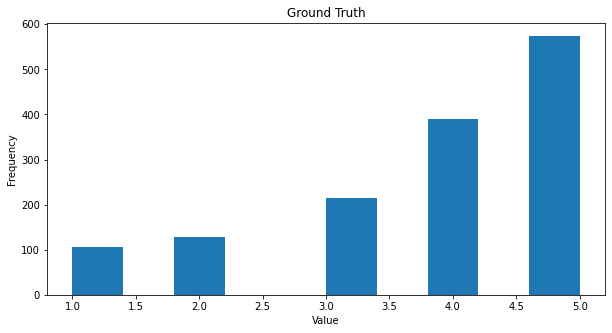

In [142]:
#what is the distrubution in ground truth scores like?
getHistogram(finaldf,'ratingScore', 'Ground Truth')

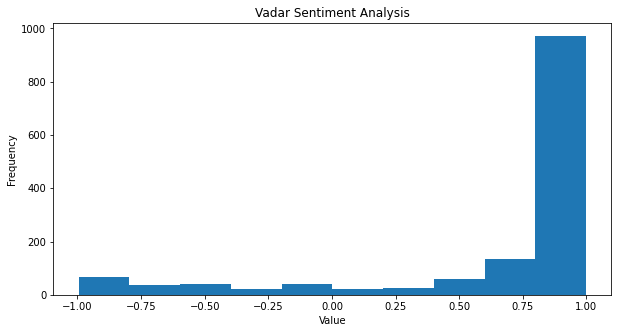

In [143]:
# what is the distrubtuion in vader scores like?
getHistogram(finaldf, 'vader', 'Vadar Sentiment Analysis')

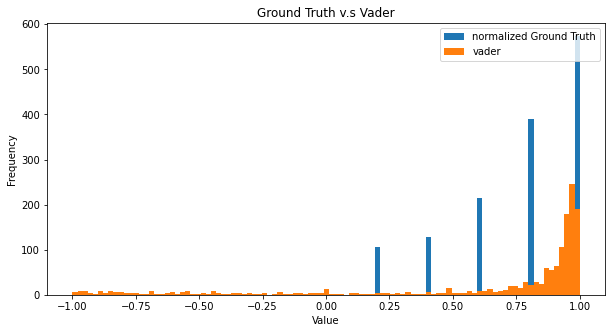

In [144]:
getHistogram(finaldf, 'both', 'Ground Truth v.s Vader')

Even though the trend in the customer ratings

In [189]:
review_count

Home Inn Express Medicine Hat                                    100
Baymont by Wyndham Medicine Hat                                  100
Days Inn by Wyndham Medicine Hat                                 100
Comfort Inn &amp; Suites Medicine Hat                            100
Hampton Inn &amp; Suites by Hilton Medicine Hat                  100
Imperial Motor Inn                                               100
Quality Inn Medicine Hat                                         100
Elkwater Lake Lodge                                              100
Travelodge Hotel Medicine Hat                                    100
Medicine Hat Lodge, Trademark Collection by Wyndham              100
Super 8 by Wyndham Medicine Hat AB                                99
Ramada Limited Medicine Hat                                       97
HomeStay Inn &amp; Suites                                         91
Sun Dek Motel                                                     26
Holiday Inn Express and Suites Med

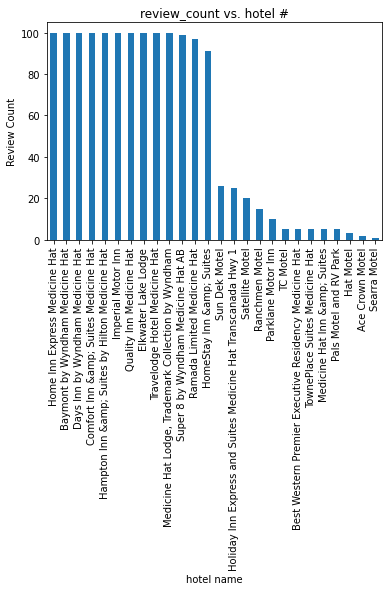

In [153]:
review_count = finaldf.hotelName.value_counts()
review_count.plot(kind='bar')
plt.title('review_count vs. hotel #')
plt.xlabel('hotel name')
plt.ylabel('Review Count')
plt.show()

### b) Boxplots

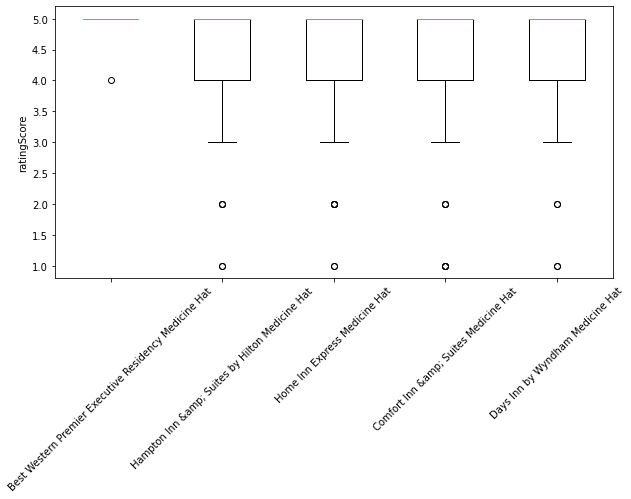

In [159]:
#rating score box plot for top 5
five_hotels = avgRatingTop5['hotelName'].values

hotel_list = []
for hotel in five_hotels:
  _hotel = finaldf.loc[finaldf['hotelName'] == hotel]['ratingScore']
  hotel_list.append(_hotel)


# multiple box plots on one figure
plt.figure(figsize=(10,5))
plt.boxplot(hotel_list)
plt.xticks(np.arange(1,6), five_hotels,rotation=45)
plt.ylabel('ratingScore')
plt.show()

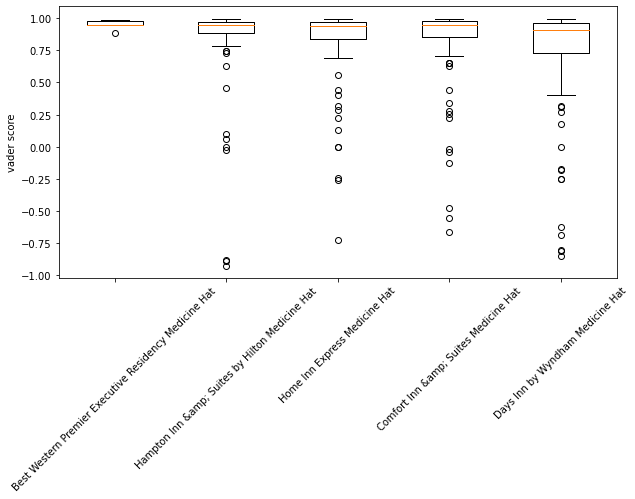

In [160]:
#vader score box plot for top 5

hotel_list = []
hotel_dict = [][]
for hotel in five_hotels:
  _hotel = finaldf.loc[finaldf['hotelName'] == hotel]['vader']
  hotel_list.append(_hotel)


# multiple box plots on one figure
plt.figure(figsize=(10,5))
plt.boxplot(hotel_list)
plt.xticks(np.arange(1,6), five_hotels,rotation=45)
plt.ylabel('vader score')
plt.show()

In [164]:
xx = finaldf.loc[finaldf['hotelName'] == hotel]['vader'].values
xx

array([ 0.9877,  0.8641,  0.9143,  0.9538,  0.9552,  0.9381,  0.9039,
        0.9209, -0.25  ,  0.9705, -0.8505,  0.9731,  0.699 ,  0.9244,
        0.9805,  0.9853,  0.8905, -0.8054,  0.9166,  0.7088,  0.1779,
        0.7501,  0.8399,  0.8655,  0.7906,  0.9588,  0.4939,  0.962 ,
        0.7713,  0.67  ,  0.7925,  0.9348,  0.987 ,  0.4019,  0.4927,
        0.8316,  0.3075,  0.5197,  0.969 ,  0.2732,  0.969 ,  0.982 ,
        0.9755,  0.6249,  0.9609,  0.9668,  0.8881,  0.9399,  0.9647,
        0.9041,  0.7269,  0.7269,  0.9353, -0.1779,  0.9409,  0.9695,
        0.835 , -0.1735,  0.7263,  0.9729,  0.7269,  0.937 , -0.6822,
        0.9929,  0.    ,  0.765 ,  0.9852,  0.7475,  0.9709,  0.9595,
        0.7902,  0.9599,  0.8479,  0.93  ,  0.9716,  0.9436,  0.5848,
        0.8748,  0.9337, -0.8071,  0.9467, -0.2516, -0.6249,  0.8247,
        0.9335,  0.9473,  0.9834,  0.9419,  0.9896,  0.32  ,  0.735 ,
        0.9461,  0.872 ,  0.7943,  0.9312,  0.9661,  0.8834,  0.8641,
        0.9595,  0.9

### c) Scatterplots and heatmaps

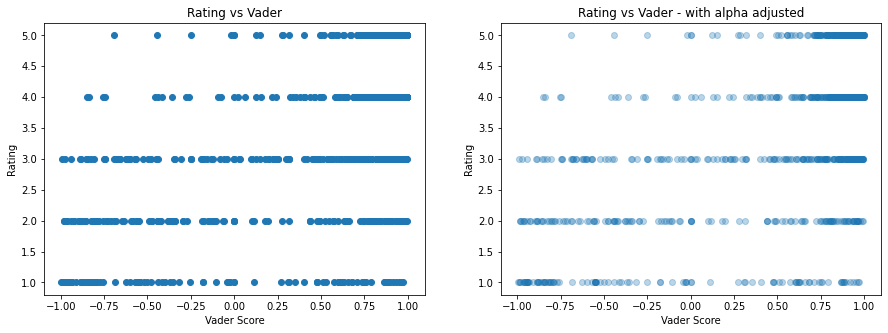

In [165]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharex=False,sharey=False)
rating_scores = finaldf['ratingScore'].values
vader_scores = finaldf['vader'].values
ax[0].plot(vader_scores, rating_scores,"o")
ax[1].plot(vader_scores, rating_scores,"o", alpha=0.3)

ax[0].set_title('Rating vs Vader')
ax[1].set_title('Rating vs Vader - with alpha adjusted')

for _ax in ax:
  _ax.set_ylabel('Rating')
  _ax.set_xlabel('Vader Score')

In [166]:
k = gaussian_kde(np.vstack([vader_scores, rating_scores]))
xi, yi = np.mgrid[vader_scores.min():vader_scores.max():vader_scores.size**0.5*1j,rating_scores.min():rating_scores.max():rating_scores.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

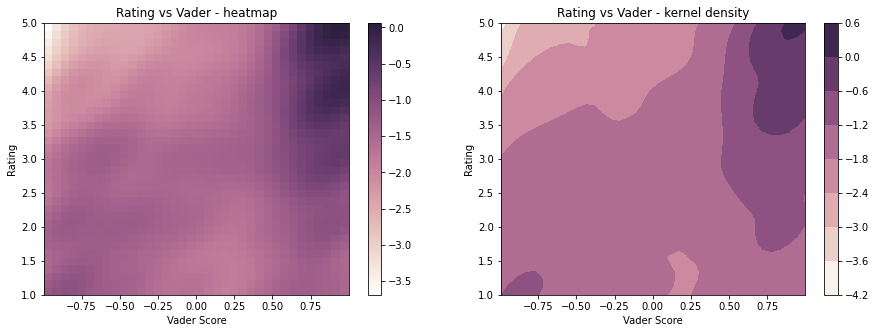

In [167]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))


b1 = ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
b2 = ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(vader_scores.min(), vader_scores.max())
ax1.set_ylim(rating_scores.min(), rating_scores.max())
ax2.set_xlim(vader_scores.min(), vader_scores.max())
ax2.set_ylim(rating_scores.min(), rating_scores.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

fig.colorbar(b1, ax=ax1)
fig.colorbar(b2, ax=ax2)

ax1.set_title('Rating vs Vader - heatmap')
ax2.set_title('Rating vs Vader - kernel density');

### d) location based patterns

In [168]:
def make_address(row):
  # individual columns need to be combined
  return row['streetAddress']+", "+row['City']+", "+row['Province']

In [170]:
# Need the location for each hotel in a format the tool can handle

geo_rating_df = avg_rating_df\
                         .join(hotelData.groupby('hotelName')\
                         .agg({'streetAddress':'max','City':'max','Province':'max','postalCode':'max'}))
geo_rating_df['formed_address'] = geo_rating_df.apply(make_address , axis=1)
geo_rating_df.tail()

,AverageVader,AverageRatingScore,n_reviews,streetAddress,City,Province,postalCode,formed_address
hotelName,,,,,,,,
Sun Dek Motel,0.204573,2.307692,26,855 Gershaw Dr SW,Medicine Hat,Alberta,T1A 7Y3,"855 Gershaw Dr SW, Medicine Hat, Alberta"
Super 8 by Wyndham Medicine Hat AB,0.519438,3.202020,99,1280 Trans Canada Way SE,Medicine Hat,Alberta,T1B 1J5,"1280 Trans Canada Way SE, Medicine Hat, Alberta"
TC Motel,0.188980,3.000000,5,780 8 St SW,Medicine Hat,Alberta,T1A 4M6,"780 8 St SW, Medicine Hat, Alberta"
TownePlace Suites Medicine Hat,0.857960,4.000000,5,7 Stober Bay SE,Medicine Hat,Alberta,T1B 4Y2,"7 Stober Bay SE, Medicine Hat, Alberta"
Travelodge Hotel Medicine Hat,0.528204,3.520000,100,1100 Redcliff Dr SW,Medicine Hat,Alberta,T1A 5E5,"1100 Redcliff Dr SW, Medicine Hat, Alberta"


In [171]:
# 0 - need to give the tool a generic name.
locator = Nominatim(user_agent='myGeocoder')
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2 - form the location string
geo_rating_df['location'] = geo_rating_df['formed_address'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
geo_rating_df['point'] = geo_rating_df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
geo_rating_df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(geo_rating_df['point'].tolist(), index=geo_rating_df.index)

geo_rating_df.head()

,AverageVader,AverageRatingScore,n_reviews,streetAddress,City,Province,postalCode,formed_address,location,point,latitude,longitude,altitude
hotelName,,,,,,,,,,,,,
Ace Crown Motel,-0.023300,3.00,2,633 14 St SW,Medicine Hat,Alberta,T1A 4V5,"633 14 St SW, Medicine Hat, Alberta","(Bel-Aire Motel, 633, 14 Street Southwest, Med...","(50.0258836, -110.70119330271979, 0.0)",50.025884,-110.701193,0.0
Baymont by Wyndham Medicine Hat,0.784708,4.27,100,3216 13 Ave SE,Medicine Hat,Alberta,T1B 1H8,"3216 13 Ave SE, Medicine Hat, Alberta","(13 Avenue SE, Southridge Heritage Estates, Me...","(49.9942778, -110.6691287, 0.0)",49.994278,-110.669129,0.0
Best Western Premier Executive Residency Medicine Hat,0.948860,4.80,5,35 Paul Stober Dr SE,Medicine Hat,Alberta,T1B 4Y2,"35 Paul Stober Dr SE, Medicine Hat, Alberta","(Paul Stober Drive Southeast, Medicine Hat, Al...","(49.995379, -110.6414638, 0.0)",49.995379,-110.641464,0.0
Comfort Inn &amp; Suites Medicine Hat,0.811451,4.38,100,2317 Trans Canada Way SE,Medicine Hat,Alberta,T1B 4E9,"2317 Trans Canada Way SE, Medicine Hat, Alberta","(Trans Canada Way SE, Medicine Hat, Alberta, T...","(50.0028329, -110.6523221, 0.0)",50.002833,-110.652322,0.0
Days Inn by Wyndham Medicine Hat,0.714159,4.36,100,24 Strachan Court SE Dunmore Rd & Trans Canada,Medicine Hat,Alberta,T1B 4R7,24 Strachan Court SE Dunmore Rd & Trans Canada...,None,None,NaN,NaN,NaN


In [182]:
map1 = folium.Map(
    location=[50.03928, -110.67661], # <- this will need to be set based on your own hotels
    tiles='cartodbpositron',
    zoom_start=12,
)

geo_rating_df.dropna().apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]], color='#d7191c').add_to(map1), axis=1)

map1



In [176]:
map1.save('map.html')

In [174]:
## folium graphs are best saved as screenshot images to be reloaded into the notebook

from IPython.display import Image
Image('demo.png')

### e) Temporal analysis

In [191]:
#2 best, 2 medium, 2 lowly rated
six_hotels = ['Baymont by Wyndham Medicine Hat','Home Inn Express Medicine Hat','Super 8 by Wyndham Medicine Hat AB','Travelodge Hotel Medicine Hat','Sun Dek Motel','Parklane Motor Inn']

In [195]:
hotelData.loc[hotelData['hotelName'].isin(six_hotels)]


,filePath,hotelName,reviewColumn,ratingScore,groundTruth,date_stamp,streetAddress,City,Province,postalCode
0,./data/ca/154920/188360/748524190.html,Super 8 by Wyndham Medicine Hat AB,"""It was okay could us a couple upgrades. The s...",3,negative,"March 1, 2020",1280 Trans Canada Way SE,Medicine Hat,Alberta,T1B 1J5
1,./data/ca/154920/188360/349234610.html,Super 8 by Wyndham Medicine Hat AB,"""There was nothing fancy about this motel but ...",3,negative,"February 19, 2016",1280 Trans Canada Way SE,Medicine Hat,Alberta,T1B 1J5
2,./data/ca/154920/188360/439044260.html,Super 8 by Wyndham Medicine Hat AB,"""Base bord heaters were not working in room wa...",3,negative,"November 21, 2016",1280 Trans Canada Way SE,Medicine Hat,Alberta,T1B 1J5
3,./data/ca/154920/188360/425446798.html,Super 8 by Wyndham Medicine Hat AB,"""We stayed here on our way to Calgary and aga...",4,positive,"October 5, 2016",1280 Trans Canada Way SE,Medicine Hat,Alberta,T1B 1J5
4,./data/ca/154920/188360/420988714.html,Super 8 by Wyndham Medicine Hat AB,"""The first visit there we were not impressed. ...",5,positive,"September 21, 2016",1280 Trans Canada Way SE,Medicine Hat,Alberta,T1B 1J5
...,...,...,...,...,...,...,...,...,...,...
1279,./data/ca/154920/182336/215642169.html,Parklane Motor Inn,"""This was a really nice motel! Vicki at the fr...",5,positive,"July 15, 2014",780-7th Street Southwest,Medicine Hat,Alberta,T1A 4L2
1280,./data/ca/154920/182336/182865026.html,Parklane Motor Inn,"""I stayed here last year for a sports event; h...",2,negative,"October 29, 2013",780-7th Street Southwest,Medicine Hat,Alberta,T1A 4L2
1281,./data/ca/154920/182336/139588050.html,Parklane Motor Inn,"""I have stayed here a couple of times now, and...",3,negative,"September 6, 2012",780-7th Street Southwest,Medicine Hat,Alberta,T1A 4L2
1282,./data/ca/154920/182336/185614788.html,Parklane Motor Inn,"""THough the staff was friendly, it certainly w...",2,negative,"November 23, 2013",780-7th Street Southwest,Medicine Hat,Alberta,T1A 4L2


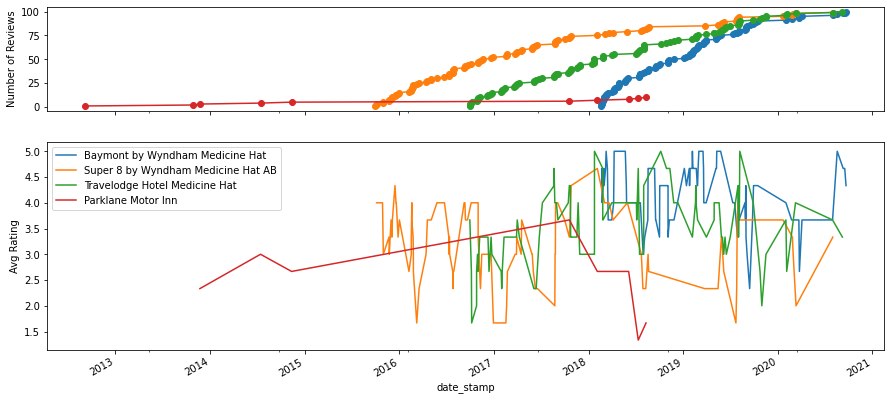

In [197]:
# It can be useful to see when reviews were being made and how the ratings changed using a running mean
fig, ax = plt.subplots(2, 1, figsize=(15,7),
                       sharex=True,
                       gridspec_kw={
                           'height_ratios': [1, 2]})

for hotel in six_hotels: 
  _df = hotelData[hotelData['hotelName']==hotel].set_index('date_stamp')
  try:
    _df.index = pd.to_datetime(_df.index)
  except:
    continue
  _df = _df.sort_index()
  _df['count'] = 1
  _df['count'].cumsum().plot(ax=ax[0],label=hotel, marker='o')
  _df['ratingScore'].rolling(3).mean().plot(ax=ax[1],label=hotel)

ax[1].set_ylabel('Avg Rating')
ax[0].set_ylabel('Number of Reviews')
plt.legend()

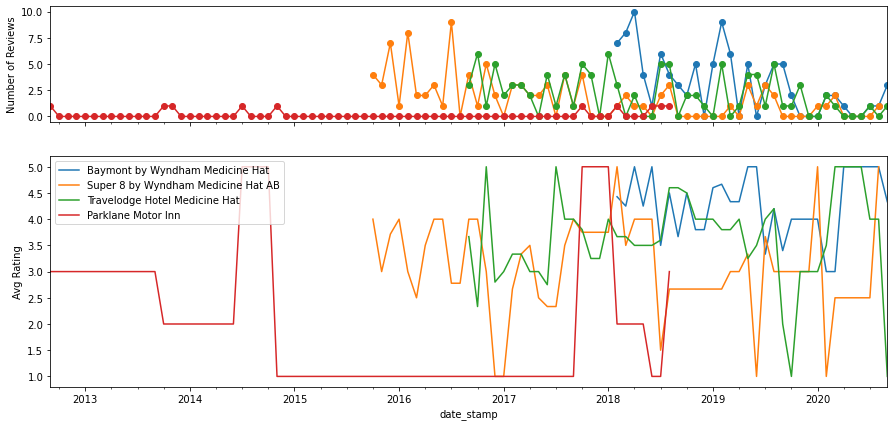

In [201]:
# It can be useful to see when reviews were being made and how the ratings changed
fig, ax = plt.subplots(2, 1, figsize=(15,7),
                       sharex=True,
                       gridspec_kw={
                           'height_ratios': [1, 2]})

for hotel in six_hotels: 
  _df = hotelData[hotelData['hotelName']==hotel].set_index('date_stamp')
  try:
    _df.index = pd.to_datetime(_df.index)
  except:
    continue
  _df = _df.sort_index()
  _df['count'] = 1
  _df_monthly = _df.groupby(pd.Grouper(freq='M')).agg({'count':'sum','ratingScore':'mean'})
  _df_monthly['ratingScore'] = _df_monthly['ratingScore'].fillna(method='ffill') # hold the last rating constant in months with no reviews
  _df_monthly['count'].plot(ax=ax[0],label=hotel, marker='o')
  _df_monthly['ratingScore'].plot(ax=ax[1],label=hotel)

ax[1].set_ylabel('Avg Rating')
ax[0].set_ylabel('Number of Reviews')
plt.legend()